# Analysing the GHCN-daily temperature dataset using Numpy

- **NCEI** (National Centers for Environmental Information) is an institution in the US providing data about the environment. It has been created by merging three fromer data centers (National Climatic Data Center, the National Geophysical Data Center, and the National Oceanographic Data Center) into a laerger one


> NCEI is responsible for hosting and providing access to one of the most significant archives on Earth, with comprehensive oceanic, atmospheric, and geophysical data. From the depths of the ocean to the surface of the sun and from million-year-old ice core records to near real-time satellite images, NCEI is the Nation’s leading authority for environmental information.

- Today, we are going to explore The Global Historical Climatology Network - Daily (GHCN-Daily dataset). It integrates daily climate observations from multiple measurement stations. The newest version contains measurements from over 90000 land-based stations worldwide, about two thirds of which are for precipitation measurement only. Other meteorological elements include, but are not limited to, daily maximum and minimum temperature, temperature at the time of observation, snowfall and snow depth. Our analysis will be dedicated to the analysis of the daily average temperature.
- The oldest station strted to record climate data about 175 years ago, on the other hand some of the stations are younger than one year. Some of the systems are updated in real-time, some of the are filled with some delay (Actually the real-time data is replaced with with archived data after some period of time)
- Data undergoes multiple quality control checks before uploading them to the database.

> Find more info about the dataset [here](https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00861)

- Daily data from the Global Historical Climatology Network are available as individual ASCII (i.e., plain text) files (one file per station) and as a GZIP-compressed TAR file containing all of the station files. Access to Online data files is available through FTP and HTTP Access

---

Let me quickly summarize the topics that will be covered today in our analysis.
We will learn:
- How to download data from an FTP server using Python
- How to use the GHCN-daily temperature dataset?
- How to find the ID and name of the available temperature stations?
- How to import daily temperature readings into Numpy?
- How to handle missing data?
- How to smooth time-based data (using moving average) in Numpy?
- How to resample daily data into monthly averages?
- How to compare monthly averages using matplotlib?

Tasks for practicing the learned skills will be at the end of this lecture

---

### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import datetime as dt

In [2]:
%matplotlib inline

#%matplotlib notebook

---

### Download the data from FTP

There are multiple ways to download the dataset, today we are going to use NOAA's FTP server: [ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily)

There is a readme file in the root folder of the FTP descibing the format and the structure of the data.

First, we are going to download readme.txt using the `urllib` module

In [3]:
def download_file(file_url, output_file):
    '''
    Download and save a file from the provided url
    '''
    urllib.request.urlretrieve(file_url, output_file)
    return '{0} downloaded succesfully'.format(output_file)


In [4]:
ftp_url = 'ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/'

In [5]:
file_name = 'readme.txt'
download_url = urllib.parse.urljoin(ftp_url, file_name)

#download_file(download_url, file_name)

# If you have already downloaded the file, you dont need to re-run this cell.
# Or you can comment the code out

> If you have already downloaded the file, you dont need to re-run this cell.
Or you can comment out the for download_file()

---
There is a file containing information about the weather stations `ghcnd-stations.txt`. The structure of the file is described on lines 393 - 405

In [6]:
with open('readme.txt','r') as readme_file:
    for line in readme_file.readlines()[392:405]:
        print(line.rstrip())

------------------------------
Variable   Columns   Type
------------------------------
ID            1-11   Character
LATITUDE     13-20   Real
LONGITUDE    22-30   Real
ELEVATION    32-37   Real
STATE        39-40   Character
NAME         42-71   Character
GSN FLAG     73-75   Character
HCN/CRN FLAG 77-79   Character
WMO ID       81-85   Character
------------------------------


Check the readme file for column description
Important note: We are going to work with the GSN stations (having the GSN flag in the corresponding column)

GSN stands for GCOS Surface Network - The GSN is a baseline network comprising a subset of about 1000 stations chosen mainly to give a fairly uniform spatial coverage from places where there is a good length and quality of data record. 
>At a later stage we will use this network to predict data on locations between stations.

Right now we are going to extract: ID, NAME, GSN FLAG from the ghcnd-stations.txt file

---
Download ghcnd-stations.txt

In [7]:
file_name = 'ghcnd-stations.txt'
output_name = 'stations.txt'
download_url = urllib.parse.urljoin(ftp_url, file_name)

#download_file(download_url, output_name)

> If you have already downloaded the file, you dont need to re-run this cell.
Or you can comment out the for download_file()

---
> **CODE_NOTE**: as it contains Latitude, Longitude, Elevation, maybe we can create some tasks with distance calculations

> [Link nr.1](https://stackoverflow.com/questions/33111529/calculating-distance-between-two-points-using-latitude-longitude-and-altitude-e)

> [Link nr.2](https://pypi.python.org/pypi/geopy)

---

**Check the content of stations.txt**

In [8]:
with open('stations.txt','r') as readme_file:
    for line in readme_file.readlines()[:10]:
        print(line.rstrip())

ACW00011604  17.1167  -61.7833   10.1    ST JOHNS COOLIDGE FLD
ACW00011647  17.1333  -61.7833   19.2    ST JOHNS
AE000041196  25.3330   55.5170   34.0    SHARJAH INTER. AIRP            GSN     41196
AEM00041194  25.2550   55.3640   10.4    DUBAI INTL                             41194
AEM00041217  24.4330   54.6510   26.8    ABU DHABI INTL                         41217
AEM00041218  24.2620   55.6090  264.9    AL AIN INTL                            41218
AF000040930  35.3170   69.0170 3366.0    NORTH-SALANG                   GSN     40930
AFM00040938  34.2100   62.2280  977.2    HERAT                                  40938
AFM00040948  34.5660   69.2120 1791.3    KABUL INTL                             40948
AFM00040990  31.5000   65.8500 1010.0    KANDAHAR AIRPORT                       40990


### Parse the selected columns from stations.txt

We can write a generic function to parse data from fixed width text file. This function is actually a wrapper around
numpy.genfromtxt().

Official documentation for [numpy.genfromtxt()](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.genfromtxt.html) 
- It is used to import data from text files, and can handle missing data
- It is possible to import character separated files or fixed width files (our dataset contains the latter)

In [9]:
def parse_fixed_file(file_name, 
                     file_delimiter,
                     selected_columns,
                     column_types):
    '''
    wrapper around np.genfromtxt()

    :param file_name: name of the file to import
    :type file_name: str
    :param file_delimiter: sequence containing width delimiters
    :type file_delimiter: sequence    
    :param selected_columns: sequence contianing name of the columns to import
    :type selected_columns: sequence    
    :param column_types: dtype of the columns
    :type column_types: numpy.dtype    
    :returns: numpy.ndarray numpy array containing the imported data
    '''
    return np.genfromtxt(file_name,
                         delimiter = file_delimiter,
                         usecols = selected_columns,
                         dtype = column_types)

> **CODE_NOTE** explain structured arrays and dtypes

In [10]:
file_delimiter = (11, 9, 10, 7, 3, 31, 4, 4, 6) # the widths of columns are in the readme file
selected_columns = [0, 5, 6] # ID, NAME, GSN_FLAG - right now we need only these three columns

# Note: Don't forget about the difference between bytes and strings in Python
# 3 tuples of column types
# Example: ('ID', 'U11') - 'ID' name of the column, 'U11' - type of the data and its length: 11 length unciode string
column_types = np.dtype([('ID', 'U11'),
                         ('NAME', 'S31'),
                         ('GSN_FLAG', 'U4')])

stations_raw = parse_fixed_file(file_name='stations.txt',
                                file_delimiter=file_delimiter,
                                selected_columns=selected_columns,
                                column_types=column_types)

In [11]:
stations_raw

array([('ACW00011604', b' ST JOHNS COOLIDGE FLD         ', '    '),
       ('ACW00011647', b' ST JOHNS                      ', '    '),
       ('AE000041196', b' SHARJAH INTER. AIRP           ', ' GSN'), ...,
       ('ZI000067977', b' BUFFALO RANGE                 ', '    '),
       ('ZI000067983', b' CHIPINGE                      ', ' GSN'),
       ('ZI000067991', b' BEITBRIDGE                    ', '    ')], 
      dtype=[('ID', '<U11'), ('NAME', 'S31'), ('GSN_FLAG', '<U4')])

In [12]:
stations_raw.shape

(104126,)

**Find stations with the GSN flag**

In [13]:
gsn_stations = np.array([station for station in stations_raw if 'GSN' in station[2]])
len(gsn_stations)

991

Only 991 out of 104126 are GSN stations

Lets strip out the whitespaces from the station names (it could have been done in the previous step)

In [14]:
gsn_stations['NAME'] = np.array([station_name.strip() for station_name in list(gsn_stations['NAME'])])
gsn_stations[:10]

array([('AE000041196', b'SHARJAH INTER. AIRP', ' GSN'),
       ('AF000040930', b'NORTH-SALANG', ' GSN'),
       ('AG000060390', b'ALGER-DAR EL BEIDA', ' GSN'),
       ('AG000060590', b'EL-GOLEA', ' GSN'),
       ('AG000060611', b'IN-AMENAS', ' GSN'),
       ('AG000060680', b'TAMANRASSET', ' GSN'),
       ('AJ000037989', b'ASTARA', ' GSN'),
       ('ALM00013615', b'TIRANA RINAS', ' GSN'),
       ('AM000037781', b'ARAGAC VISOKOGORNAYA', ' GSN'),
       ('AO000066160', b'LUANDA', ' GSN')], 
      dtype=[('ID', '<U11'), ('NAME', 'S31'), ('GSN_FLAG', '<U4')])

Create a dictionary from these stations: station_name - keys, stations_id - values

In [15]:
# Create a dictionary from these stations
# 
station_mapping = {station[1]: station[0] for station in gsn_stations}

In [16]:
list(station_mapping.keys())[:10]

[b'SHARJAH INTER. AIRP',
 b'NORTH-SALANG',
 b'ALGER-DAR EL BEIDA',
 b'EL-GOLEA',
 b'IN-AMENAS',
 b'TAMANRASSET',
 b'ASTARA',
 b'TIRANA RINAS',
 b'ARAGAC VISOKOGORNAYA',
 b'LUANDA']

In [17]:
def find_station_id(station_mapping, station_name):
    '''
    returns the id of the provided station name

    :param station_mapping: dict name of the file to import
    :type station_mapping: dict
    :param station_name: name of the station we are looking for
    :type station_mapping: str
    :returns: id of the station
    '''
    return station_mapping.get(station_name.encode(), None)

---

## Download daily data for a selected station

Select a station for analysis. Change the variable `station_name`

[Here](https://www.dwd.de/EN/climate_environment/climatemonitoring/climatedatacenter/gsnmc/editorial/gsnlistmap/GSN_Station_Region_2013_pdf.pdf?__blob=publicationFile&v=3) is a list of available stations

---
>*Interactive widgets*

from ipywidgets import widgets
from IPython.display import display

text_input = widgets.Text()
display(text_input)

output_variable = widgets.Text()

def handle_submit(sender):
    output_variable.value = text_input.value
    print(output_variable.value)
    

text_input.on_submit(handle_submit)

In [18]:
station_name = 'POPRAD/TATRY'

Download the daily summary file for the selected station

In [19]:
station_id = find_station_id(station_mapping, station_name) # gets the ID for the selected station

file_rel_path = 'gsn/{0}.dly'.format(station_id)
output_name = 'station_daily.txt'
download_url = urllib.parse.urljoin(ftp_url, file_rel_path) # url of the daily summary 

station_file_location = download_url.format(station_id)
urllib.request.urlretrieve(station_file_location, 'station_daily.txt')

('station_daily.txt', <email.message.Message at 0xd33c0b8>)

Ok, we have downloaded the daily summary file for the selected station, but we haven't talked about the structure of the daily files

The structure is described on lines 99:121 in the readme file

In [20]:
with open('readme.txt','r') as readme_file:
    for line in readme_file.readlines()[98:121]:
        print(line.rstrip())

------------------------------
Variable   Columns   Type
------------------------------
ID            1-11   Character
YEAR         12-15   Integer
MONTH        16-17   Integer
ELEMENT      18-21   Character
VALUE1       22-26   Integer
MFLAG1       27-27   Character
QFLAG1       28-28   Character
SFLAG1       29-29   Character
VALUE2       30-34   Integer
MFLAG2       35-35   Character
QFLAG2       36-36   Character
SFLAG2       37-37   Character
  .           .          .
  .           .          .
  .           .          .
VALUE31    262-266   Integer
MFLAG31    267-267   Character
QFLAG31    268-268   Character
SFLAG31    269-269   Character
------------------------------


---

## Manipulating daily summary files

Again this is a fixed width file, so we will need to use our `parse_fixed_file` function.

Each row contains 269 characters,

each row represents one observable for one month of data
- ID, YEAR, MONTH, ELEMENT - these 4 columns are serving as data identificators
    - ELEMENT represents the observable type (Temperature minimum, Temperature maximum, Temperature average, Percipitation, etc). We will use the temperature related observables in our analysis
- The following 31 * 4 columns are representing the actual measurements for each day in the month
    - Why 31? Thats the maximum possible number of days in a month (if a particular month has less then 31 days, the excess days    are filled with -9999)
    - Missing values are filled with -9999 as well
    - The three columns are : VALUE (this is what we are looking for), MFLAG, QFLAG, SFLAG

We need to export the following columns for our analysis:
- YEAR
- MONTH
- ELEMENT - We are going to rename it to PROCESS_TYPE
- VALUE for each day

In [21]:
file_delimiter = [11, 4, 2, 4] + [5, 1, 1, 1] * 31 # This is described in readme.txt
selected_columns = [1, 2, 3] + [4*i for i in range(1, 32)]

# column_types contains the column names and their data types
column_types = np.dtype([('YEAR', '>i4'),
                         ('MONTH', '>i4'),
                         ('PROCESS_TYPE', 'U4')] +
                        [('DAY_{0}'.format(i), '>i4') for i in range(1, 32)])

station_raw_data = parse_fixed_file(file_name='station_daily.txt',
                                    file_delimiter=file_delimiter,
                                    selected_columns=selected_columns,
                                    column_types=column_types)

Check the last 5 records in the dataset

As you can see the same month can be repeated multiple times, each time showing a different observable

In [22]:
print(station_raw_data[-5:])

[ (2017, 10, 'TAVG',  61,    75,    99,    92,    99,    70,    62,    62,    52,    62,   100,   123,   101,   102,   116,   121,    97,    89,   112,    93,    73,    61,    57,    52,    58,    98,    59,    44,    27,     1,     4)
 (2017, 11, 'TMIN', -25,    33, -9999,   -33, -9999, -9999, -9999,   -28, -9999, -9999, -9999,    -2, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999)
 (2017, 11, 'PRCP',   0,     0,    10,     0,     0,     0,     0,     0,    30,     3,     0,     8,    41, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999)
 (2017, 11, 'SNWD',  20, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999,    10, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999)
 (2017, 11, 'TAVG',  33,    73,    56,    43,    62,    54,

Let's check the the observables for the last 10 records - Select the `'PROCESS_TYPE'` column

Later on, we will write a function, which will filter the selected processing type and will reshape the data, having a separate record (row) for each day with the corresponding metric

In [23]:
print(station_raw_data['PROCESS_TYPE'][-10:])

['TAVG' 'TMAX' 'TMIN' 'PRCP' 'SNWD' 'TAVG' 'TMIN' 'PRCP' 'SNWD' 'TAVG']


In [24]:
# We will need the first year and the last year of the records for later usage

min_year = station_raw_data[0]['YEAR']
max_year = station_raw_data[-1]['YEAR']

print(min_year, max_year)

1951 2017


### Convert the data into human readable format

In [25]:
def refactor_monthly_data(monthly_data):
    '''
    Converts the raw monthly data into structured numpy array (with named columns)
    
    Creates a new record for each day.
    Original data contained 34 columns and 1 row (data from 1 month)
    output data has 2 columns and 34 rows
    '''
    year = monthly_data['YEAR']
    month = monthly_data['MONTH']
    # Later on I will show you, how to use strptime and stftime
    # in Pandas and pure Python. For now we are going to use np.datetime64
    
    start = np.datetime64('{0}-{1:02}'.format(year, month))
    month_range = np.arange(start,
                            start + np.timedelta64(1, 'M'),
                            np.timedelta64(1, 'D'))
    current_month_data = [(date, monthly_data['DAY_' + str(day_nr+1)] / 10) for
                          day_nr, date
                          in enumerate(month_range)]
    #print(np.array(current_month_data,
    #                dtype=[('DATE', 'M8[D]'), ('TEMPERATURE', 'd')]))
    return np.array(current_month_data,
                    dtype=[('DATE', 'M8[D]'), ('TEMPERATURE', 'd')])

In [26]:
def take_processing(station_data, processing_type):
    '''
    Exctracts the provided processing type from raw station data and flattens them.
    
    Structure of the result array:
    Date (format: YYYY-MM-DD), Temperature (the selected processing type)
    Original data contained 34 columns and n rows
    flattened data has 2 columns and 34*n rows
    '''
    return np.concatenate([refactor_monthly_data(raw_month)
                           for raw_month
                           in station_data
                           if raw_month[2] == processing_type])

We created two functions, they take the raw data from a station and reshape them to daily data. Each day will have its own record or row

Let's check an example:
This is the first row from station_raw_data, representing one month of data:

| YEAR | MONTH | PROCESSING_TYPE | DAY_1 | DAY_2 | DAY_3 | DAY_4 | DAY_5 | ... | DAY_26 | DAY_27 | DAY_28 | DAY_29 | DAY_30 | DAY_31 |
|------|-------|-----------------|-------|-------|-------|-------|-------|-----|--------|--------|--------|--------|--------|--------|
| 1951 | 1     |  'TMAX'         | -10   | 2     | 26    | 24    | 13    | ... | 30     | 32     | 5      | 22     | 28     | 37     |
and this is how the the data looks after processing, still the same month, but now each day has its own row:

| DATE       | TEMPERATURE |
|------------|-------------|
| 1951-01-01 | -1.0        |
| 1951-01-02 | 0.2         |
| 1951-01-03 | 2.6         |
| 1951-01-04 | 2.4         |
| 1951-01-05 | 1.3         |
| 1951-01-06 | 3.7         |
| 1951-01-07 | 0.6         |
| 1951-01-08 | 2.2         |
| 1951-01-09 | 4.2         |
| 1951-01-10 | 3.4         |
| 1951-01-11 | 4.9         |
| 1951-01-12 | 5.1         |
| 1951-01-13 | 9.4         |
| 1951-01-14 | 3.3         |
| 1951-01-15 | 4.1         |
| 1951-01-16 | 2.3         |
| 1951-01-17 | -0.9        |
| 1951-01-18 | -0.6        |
| 1951-01-19 | 0.9         |
| 1951-01-20 | 0.1         |
| 1951-01-21 | -1.4        |
| 1951-01-22 | -2.2        |
| 1951-01-23 | -5.3        |
| 1951-01-24 | -3.3        |
| 1951-01-25 | -3.3        |
| 1951-01-26 | 3.0         |
| 1951-01-27 | 3.2         |
| 1951-01-28 | 0.5         |
| 1951-01-29 | 2.2         |
| 1951-01-30 | 2.8         |
| 1951-01-31 | 3.7         |

Create 3 arrays:
- minimums - daily TMIN readings
- maximums - daily TMAX readings
- averages - daily TAVG readings

In [27]:
minimums = take_processing(station_raw_data, 'TMIN')
maximums = take_processing(station_raw_data, 'TMAX')
averages = take_processing(station_raw_data, 'TAVG')

Here you can see that different observables can have different time ranges, i.e. different measurement types were taken independently

In [28]:
print(minimums['DATE'][0], minimums['DATE'][-1])
print(maximums['DATE'][0], maximums['DATE'][-1])
print(averages['DATE'][0], averages['DATE'][-1])

1951-01-01 2017-11-30
1951-01-01 2017-10-31
1957-06-01 2017-11-30


> **Question / Task:** Create a function where you enter the station name and returns these three arrays (minimums, maximums, averages)

## First Data Analysis / Plotting

Let's create our first plot. Later on, I will explain how to use matplotlib, for now its enough to use the simplest configuration

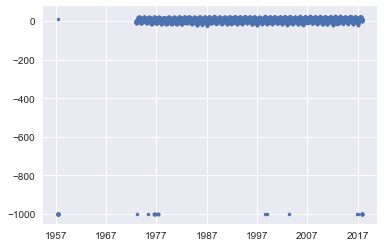

In [29]:
plt.plot(averages['DATE'], averages['TEMPERATURE'], '.')

As I told you earlier, missing values are represented as -9999 (during the processing we divided temperature values with 10, that's why we have -999.9 here)
We need to somehow get rid of the unknown values:
* easiest option - change them to np.NaN
* extrapolation

to find the elements, where the value is -999.9, use boolean indexing 

> **CODE_NOTE** explain boolean masks

In [30]:
missing_vals_mask = minimums['TEMPERATURE'] == -999.9
missing_vals_mask

array([False, False, False, ...,  True,  True,  True], dtype=bool)

In [31]:
minimums['TEMPERATURE'][missing_vals_mask] = np.nan

We can embed this functionality into the take_processing() function

> **NOTE:** There are other ways to do this

In [32]:
def take_processing(station_data,
                    processing_type):
    daily_data = np.concatenate([refactor_monthly_data(raw_month)
                                 for raw_month
                                 in station_data
                                 if raw_month[2] == processing_type])
    daily_data['TEMPERATURE'][daily_data['TEMPERATURE'] == -999.9] = np.nan
    return daily_data

In [33]:
minimums = take_processing(station_raw_data, 'TMIN')
maximums = take_processing(station_raw_data, 'TMAX')
averages = take_processing(station_raw_data, 'TAVG')

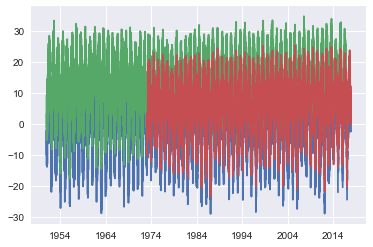

In [34]:
plt.plot(minimums['DATE'], minimums['TEMPERATURE'])
plt.plot(maximums['DATE'], maximums['TEMPERATURE'])
plt.plot(averages['DATE'], averages['TEMPERATURE'])

Ok, it looks much better, only real temperature values.
Good news is that the average temperature (red curve is always between maximum and minimum temperature)

In [35]:
np.mean(averages['TEMPERATURE'])

nan

**How to get rid of NaN values**

We can't calculate the mean for the array because it contains NaN values

As it has been explained previously, there are two options:
* Ignore NaN values
    * use numpy.nanmean()
    * create a new array without NaN values
* we can extrapolate the missing values, based on the measured values (We will do this in the Pandas chapter)

In [36]:
# 1. option
np.nanmean(averages['TEMPERATURE'])

6.4988147605083091

In [37]:
# 2. option
# To drop NaN values we need to use boolean masks

nan_val = np.isnan(averages['TEMPERATURE'])
len(averages['TEMPERATURE'][nan_val])

67

In [38]:
# number_averages contains only numeric values - NaN values are dropped

number_averages = averages[~nan_val]
len(number_averages)

16368

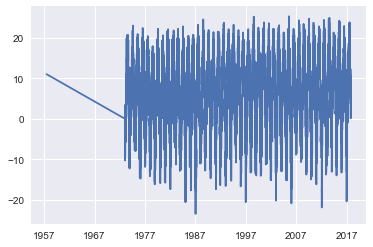

In [39]:
plt.plot(number_averages['DATE'], number_averages['TEMPERATURE'])

Compare the shapes of the original and new array

In [40]:
averages.shape, number_averages.shape

((16435,), (16368,))

## How to smooth the data

If we zoom on the data, we can see, that its very noisy, there are different techniques how to smooth the data, here we are going to use floating average.

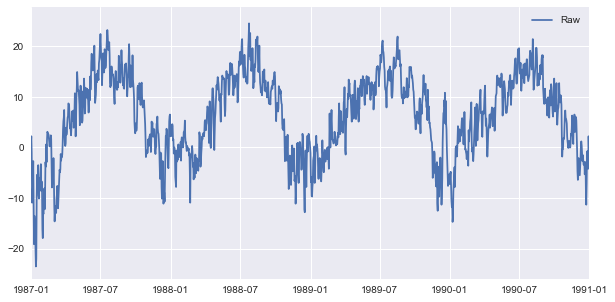

In [41]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

ax.set_xlim([np.datetime64('1987-01-01'), np.datetime64('1991-01-01')])

plt.plot(number_averages['DATE'], number_averages['TEMPERATURE'])

plt.legend(['Raw'])

In numpy, there is no direct way to apply floating average. But we can create our own functions to calculate floating average

Method nr.1 for calculating the floating average is to use correlation / convolution

In [42]:
def floating_avg(dataset, column_name, window=5):
    return np.correlate(dataset[column_name], np.ones((window,))/window, mode='same')

Method nr.2 for calculating the floating average is through cumulative sum

> **CODE_NOTE** To be done

---
Let's see how floating average works in real action
Plot floating average over 100 samples and 200 samples and compare it with the oroginal temperature values

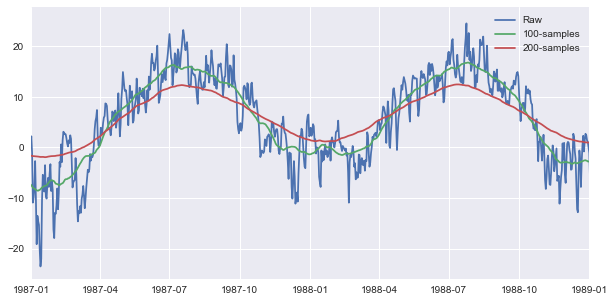

In [43]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

ax.set_xlim([np.datetime64('1987-01-01'), np.datetime64('1989-01-01')])

plt.plot(number_averages['DATE'], number_averages['TEMPERATURE'])
plt.plot(number_averages['DATE'], floating_avg(number_averages, 'TEMPERATURE', 60))
plt.plot(number_averages['DATE'], floating_avg(number_averages, 'TEMPERATURE', 200))

plt.legend(['Raw', '100-samples', '200-samples'])

> **Note:** This a very rough way to calculate floating average - because the moving window is applied over a constant number of samples, but if there is a discontinuity in the samples, the time window would be variable (in one 100 samples corresponds to 100 days, in other cases it can correspond to higher number of days). It is possible to overcome this problem in Numpy, but we won't talk about it right now, and will show you a possible solution in Pandas.

> **CODE_NOTE** Useful resources:
- http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html
- https://stackoverflow.com/questions/41311268/python-operation-on-sub-dimension-of-a-numpy-array

## Calculating monthly averages

In the next part we are going to calculate monthly averages from the daily averages

> **Question** Could you think of a solution, how we can achieve this on the `station_raw_data` array?

In [44]:
def get_monthly_data(dataset, year):
    '''
    calculates the average value for each month in the provided year
    
    returns a 12x1 array
    '''
    act_monthly_avg = np.full((12, ), np.nan)
    for month_nr in range(1, 12+1):
        start_date = np.datetime64('{0}-{1:02}'.format(year, month_nr))
        end_date = start_date + np.timedelta64(1,'M')
        selected_range = number_averages[(number_averages['DATE'] >= start_date) &
                                         (number_averages['DATE'] <= end_date)]['TEMPERATURE']
        if not np.isnan(selected_range).all():
            act_monthly_avg[month_nr - 1] = np.mean(selected_range)
    return act_monthly_avg

In [45]:
def process_years(dataset, start_year, end_year):
    '''
    processes each year between start_year and end_year
    
    use get_monthly_data() and adds the year as the 1st element
    of the array
    '''
    all_year_summary = None
    for act_year in np.arange(start_year, end_year + 1):
        act_monthly_avg = get_monthly_data(dataset, act_year)
        act_monthly_avg = np.insert(act_monthly_avg, 0 , act_year)
        if all_year_summary is None:
            all_year_summary = act_monthly_avg
            continue
        
        all_year_summary = np.vstack((all_year_summary, act_monthly_avg))
    return all_year_summary

In [46]:
result_array = process_years(number_averages, min_year, max_year)
result_array.shape

(67, 13)

`result_array` processes every year between `min_year` and `max_year` (`max_year` is inclusive). The shape of the resulting array is: *number_of_years* x *13*

Why 13?
- 1st element is the year
- 2nd-13th element  average temperature for each month in that year


In [47]:
result_array[0]

array([ 1951.,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan])

Here we can see, how the first year in our array looks like (first year of the analysis)

---
Ok, let's create a bar plot from the last year. So we can see, how the monthly average temperatures have chenged change during the year

<Container object of 12 artists>

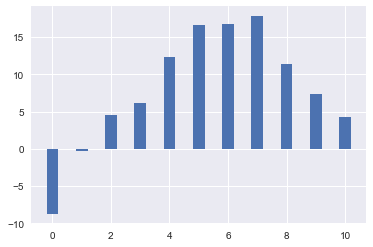

In [48]:
fig, ax = plt.subplots()
def_width = 0.4

ax.bar(left=np.arange(12), height=result_array[-1][1:], width=def_width)

---
Column 1 - Column 13 are representing the months of the year. If we access one of these columns, we can see how the data evolved over the year. E.g. january is the 1st column in the array and we can access it using the following numpy indexing - `result_array[:, 1]`, where:
- the first slice selects all rows
- the second index selects column nr. 1

Next, we create two arrays. One for january and one for june. Then we create 2 bar plots to show how the average temperature evolves in these 2 months.

<Container object of 67 artists>

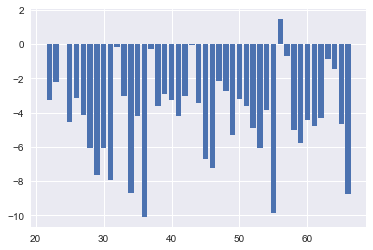

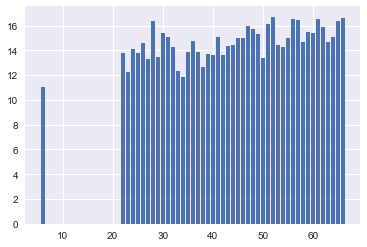

In [49]:
fig, ax = plt.subplots()

left_range = np.arange(result_array.shape[0])
january_data = result_array[:, 1]

ax.bar(left=left_range, height=january_data)

june_data = result_array[:, 6]
fig, ax = plt.subplots()
ax.bar(left=left_range, height=june_data)

Ok, let's do something more interesting. Compare 2 consecutive months in one chart (january and february for example)

<Container object of 67 artists>

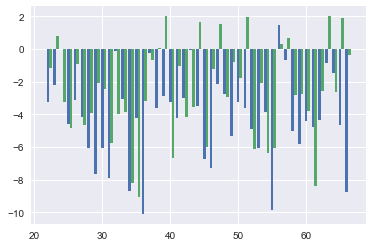

In [50]:
fig, ax = plt.subplots()
def_width = 0.4
left_range = np.arange(result_array.shape[0])
january_data = result_array[:, 1]
february_data = result_array[:, 2]

ax.bar(left=left_range, height=january_data, width=def_width)
ax.bar(left=left_range + def_width, height=february_data, width=def_width)

Not so bad, but the labels on the x axis are not very informative. We want to see the actual years instead of these numbers

---
**Structured arrays**

Structured arrays (record arrays) are very similar to dataframes in Pandas. With structured arrays we can convert our numpy arrays into tabular data, where data can be accessed through named fields - Like in excel, where you refer to a cell through the *column name* and *row number*

In [51]:
structured_result = np.core.records.fromarrays(result_array.transpose(),
                                               dtype=[('year', '<i4')] +
                                                     [('month_{0}'.format(i+1), '<f8') for i in range(12)])


Let's check the dtypes of our structured result
- The first element in each tuple is the name of the "column"
- So again, we have 13 columns (year and 12 months)

In [59]:
structured_result[-1:].dtype

dtype((numpy.record, [('year', '<i4'), ('month_1', '<f8'), ('month_2', '<f8'), ('month_3', '<f8'), ('month_4', '<f8'), ('month_5', '<f8'), ('month_6', '<f8'), ('month_7', '<f8'), ('month_8', '<f8'), ('month_9', '<f8'), ('month_10', '<f8'), ('month_11', '<f8'), ('month_12', '<f8')]))

In [61]:
def get_month_name(month_number):
    '''
    Returns the full month name of the provided month_number
    '''
    return dt.datetime(1900, month_number, 1).strftime('%B')

---
Next, we create a scatter for the temperature evolution of each individual month

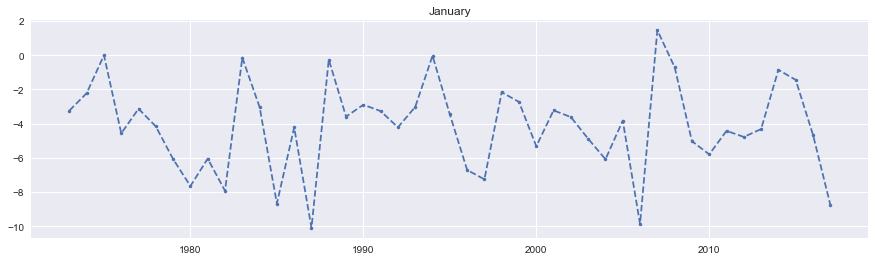

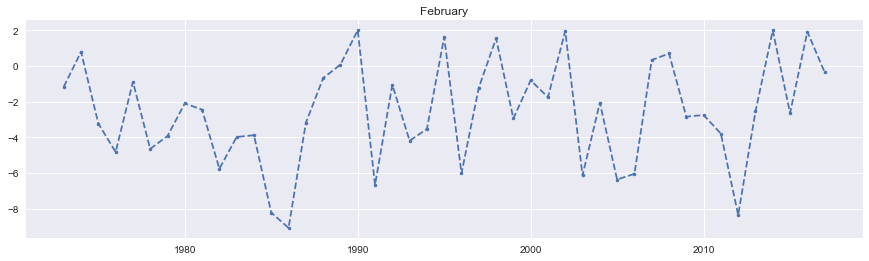

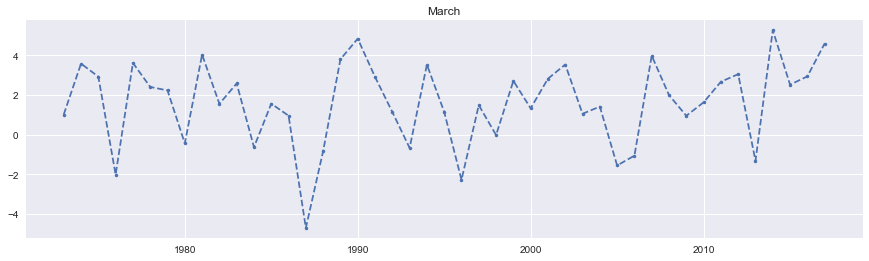

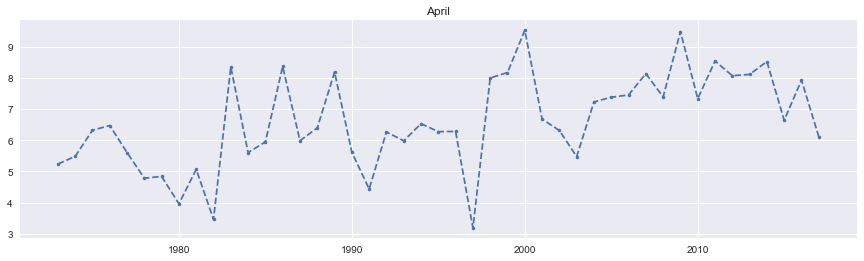

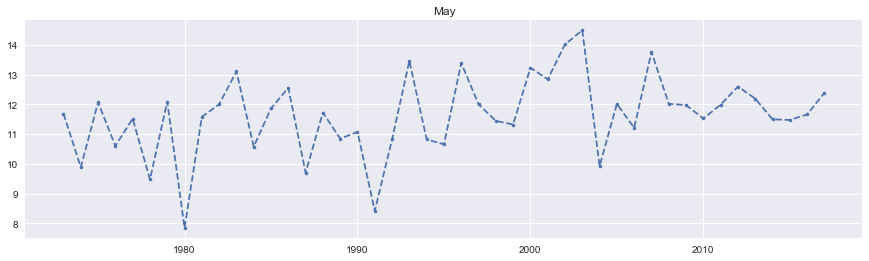

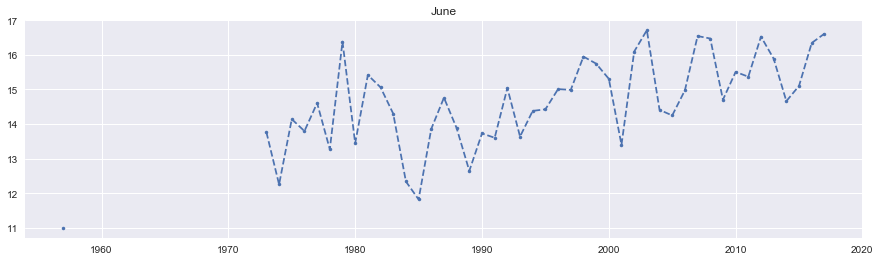

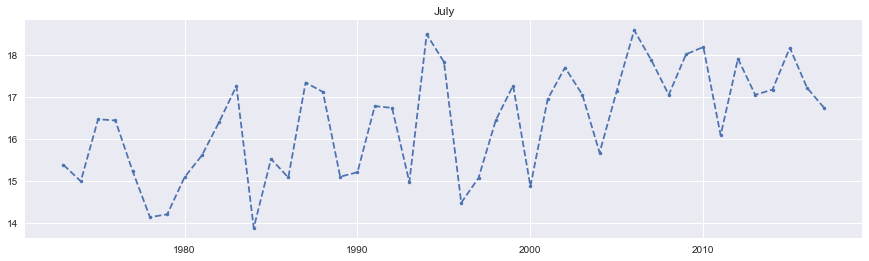

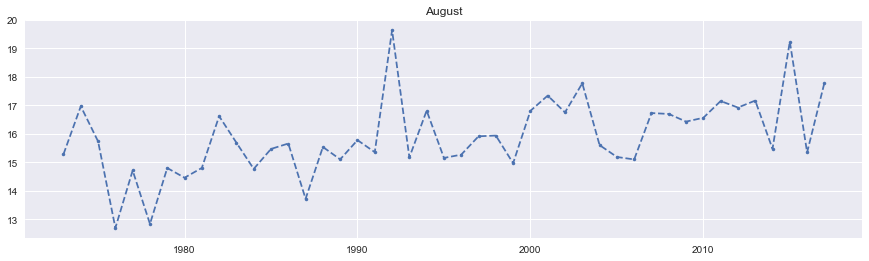

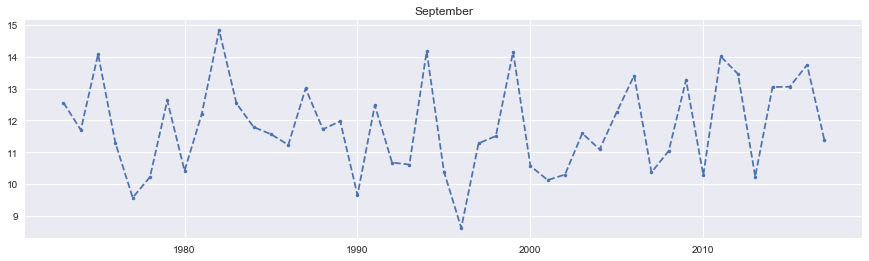

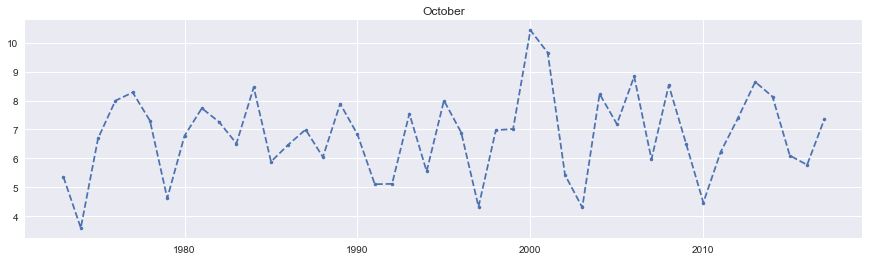

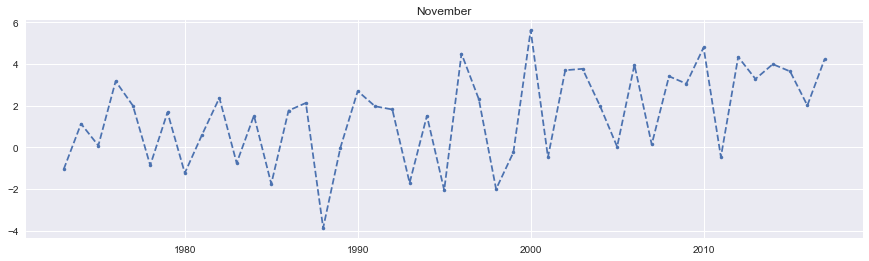

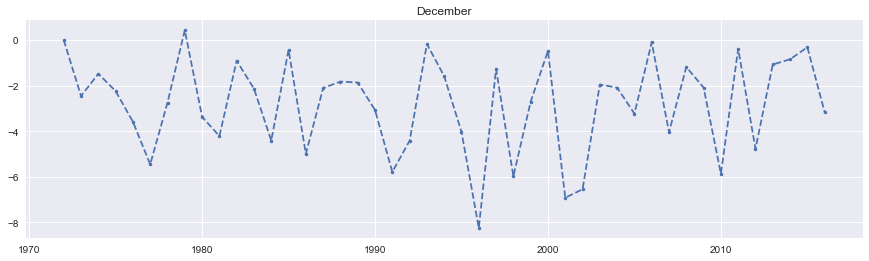

In [62]:
for i in range(12):
    fig, ax = plt.subplots()
    ax.plot(structured_result['year'], structured_result['month_{0}'.format(i + 1)], '.--')
    month_name = get_month_name(i + 1)
    ax.set_title(month_name)
    fig.set_figwidth(15)

> **Question / Task:** Can you create a function from the previous cell, which accepts a sequence of months to be plotted?

---
> **CODE_NOTE** The next cell contains the solution, it has to be hidden

In [68]:
def months_scatter_plot(temperature_dataset, months_seq=range(1, 13)):
    '''
    This function plots the evolution of the monthly average from the provided dataset
    for the provided sequence of months
    '''
    for i in months_seq:
        fig, ax = plt.subplots()
        ax.plot(temperature_dataset['year'], temperature_dataset['month_{0}'.format(i)], '.--')
        month_name = get_month_name(i)
        ax.set_title(month_name)
        fig.set_figwidth(15)

In [85]:
def months_scatter_plot(temperature_dataset, months_seq=range(1, 13)):
    '''
    This function plots the evolution of the monthly average from the provided dataset
    for the provided sequence of months
    '''
    fig, axes = plt.subplots(len(months_seq), 1)
    fig.set_figheight(len(months_seq) * 5)
    fig.set_figwidth(15)
    for i, month_number in enumerate(months_seq):
        axes[i].plot(temperature_dataset['year'], temperature_dataset['month_{0}'.format(month_number)], '.--')
        month_name = get_month_name(month_number)
        axes[i].set_title(month_name)

In [70]:
# months_scatter_plot(structured_result, [1,4])

---

Let's do the same thing with bar plots

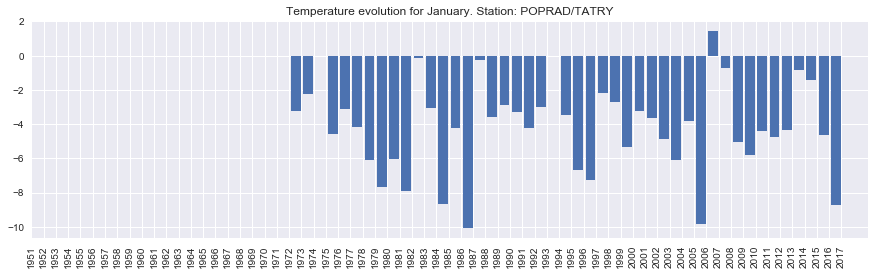

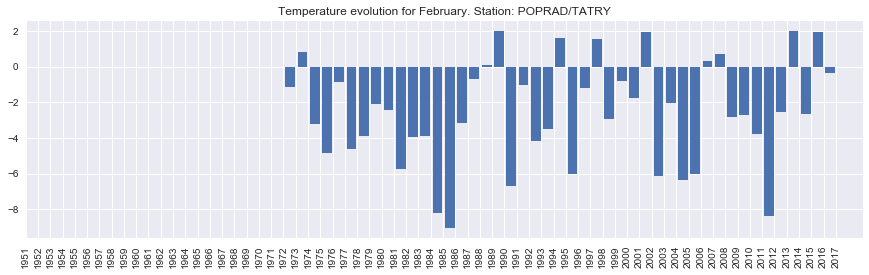

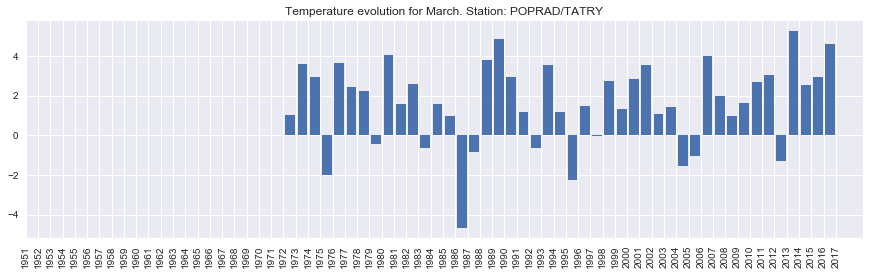

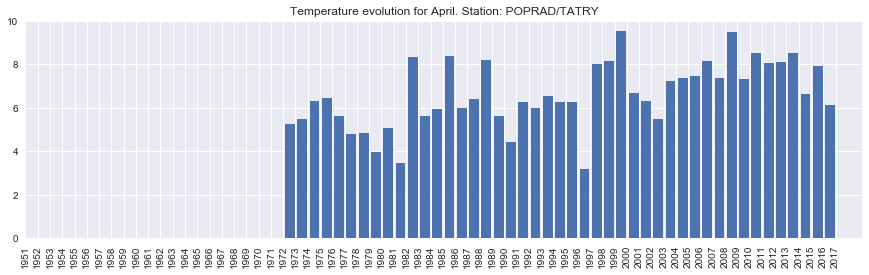

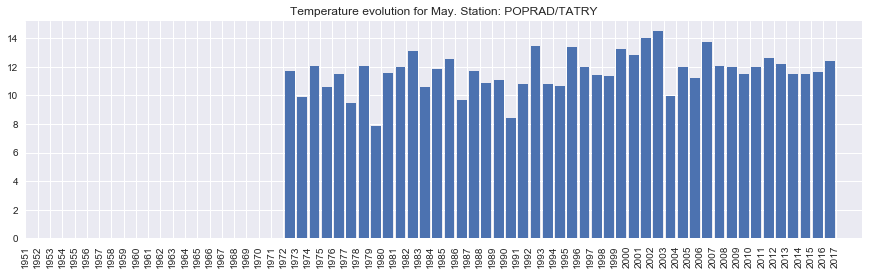

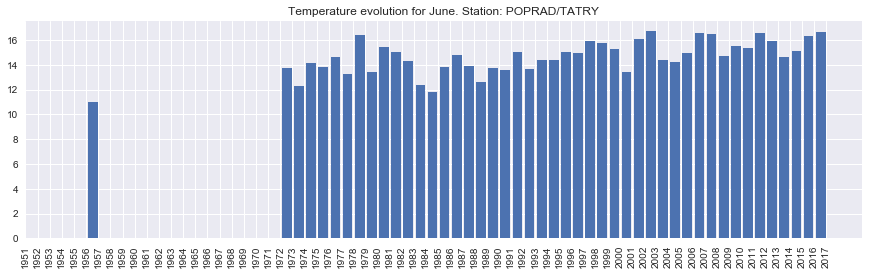

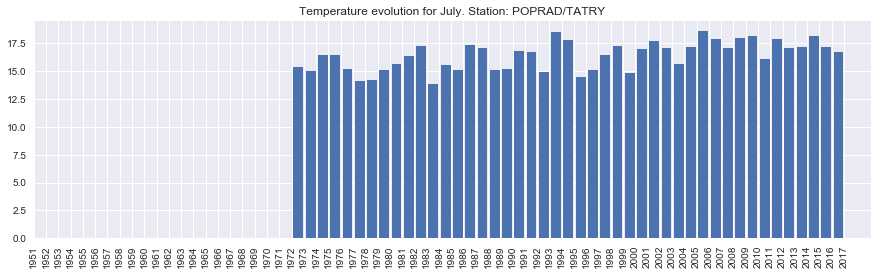

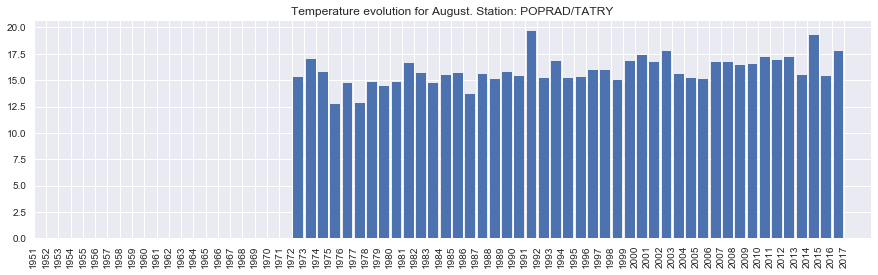

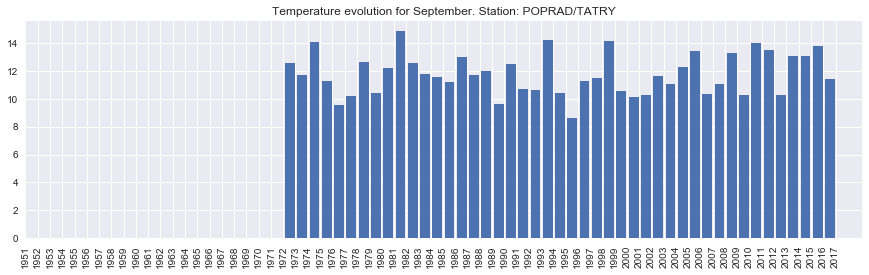

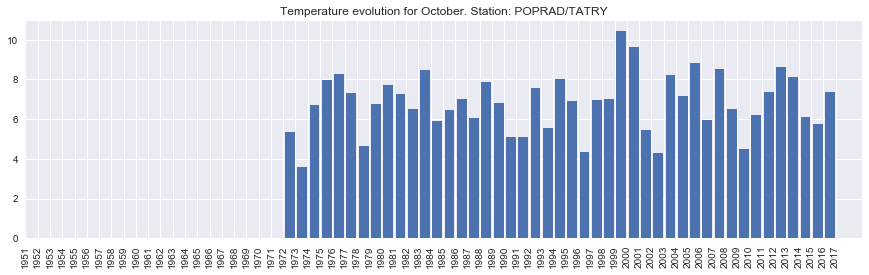

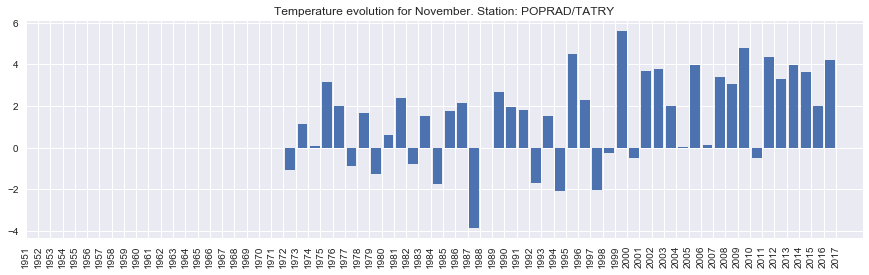

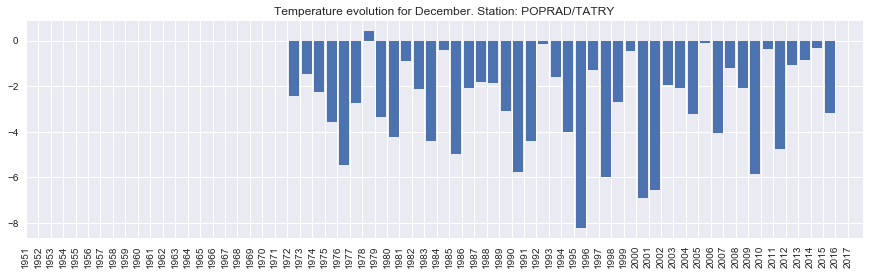

In [73]:
for i in range(12):
    cur_month = get_month_name(i + 1)
    graph_title = 'Temperature evolution for {0}. Station: {1}'.format(cur_month,
                                                                       station_name)
    fig, ax = plt.subplots()
    
    years_range = np.arange(min_year, max_year + 1)
    selected_temperatures = structured_result[np.logical_and(structured_result['year'] >= min_year,
                                                             structured_result['year'] <= max_year)]
    
    bar_width = 0.9

    ax.bar(years_range, selected_temperatures['month_{0}'.format(i + 1)], align='center')
    ax.set_xticks(years_range + bar_width / 2)    
    ax.set_xticklabels(years_range, rotation=90)
    
    fig.set_figwidth(15)
    
    ax.set_title(graph_title)
    


> **Question / Task:** Can you create a function from the previous cell, which accepts a sequence of months to be plotted?

---
> **CODE_NOTE** The next cell contains the solution, it has to be hidden

In [92]:
def months_bar_plot(temperature_dataset, months_seq=range(1, 13)):
    '''
    This function plots the evolution of the monthly average from the provided dataset
    for the provided sequence of months
    '''
    for i in months_seq:
        cur_month = get_month_name(i)
        graph_title = 'Temperature evolution for {0}. Station: {1}'.format(cur_month,
                                                                           station_name)
        fig, ax = plt.subplots()

        years_range = np.arange(min_year, max_year + 1)
        selected_temperatures = temperature_dataset[np.logical_and(structured_result['year'] >= min_year,
                                                                 structured_result['year'] <= max_year)]

        bar_width = 0.9

        ax.bar(years_range, selected_temperatures['month_{0}'.format(i + 1)], align='center')
        ax.set_xticks(years_range + bar_width / 2)    
        ax.set_xticklabels(years_range, rotation=90)

        fig.set_figwidth(15)

        ax.set_title(graph_title)

In [96]:
#months_bar_plot(structured_result, [1,4])

---

> **Question / Task:** Can you create a function which compares multiple months in the same graph using scatterplots?

---
> **CODE_NOTE** The next cell contains the solution, it has to be hidden

In [198]:
def compare_months_scatter(temperature_dataset,
                           months_seq,
                           height=5,
                           width=10):
    fig, ax = plt.subplots(1)
    curve_names = []
    for i in months_seq:
        month_name = get_month_name(i)
        curve_names.append(month_name)
        ax.plot(temperature_dataset['year'],
                temperature_dataset['month_{0}'.format(i)],
                '.--')
        ax.set_title('Monthly comparison')
    fig.set_figheight(height)
    fig.set_figwidth(width)
    legend = ax.legend(curve_names)
    legend.set_frame_on(True)
    frame = legend.get_frame()
    frame.set_edgecolor('r')

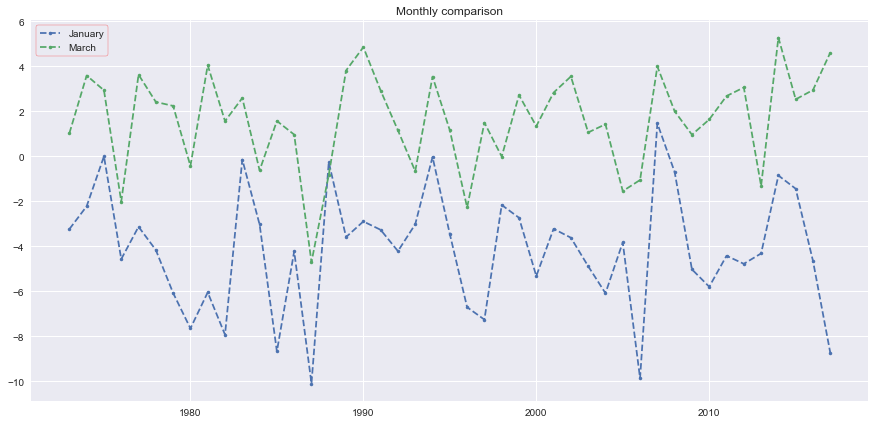

In [202]:
compare_months_scatter(structured_result, (1, 3), 7, 15)

---

> **Question / Task:** Can you create a function which compares multiple months in the same graph using bar charts?

---
> **CODE_NOTE** The next cell contains the solution, it has to be hidden

In [272]:
def compare_months_bar(temperature_dataset,
                       months_seq,
                       min_year,
                       max_year,
                       height=5,
                       width=15,
                       default_width=0.4):
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    graph_title = 'Monthly comparison'
    ax.set_title(graph_title)
    curve_names = []
    print(months_seq)
    years_range = np.arange(min_year, max_year + 1)
    bar_width = default_width * len(months_seq)
    selected_rows = temperature_dataset[np.logical_and(temperature_dataset['year'] >= min_year,
                                                       temperature_dataset['year'] <= max_year)]

    for i, month_number in enumerate(months_seq):
        cur_month = get_month_name(month_number)
        curve_names.append(cur_month)     
        ax.bar(years_range + i * (default_width),
               selected_rows['month_{0}'.format(month_number)],
               align='center',
               width=default_width)
        ax.set_xticks(years_range + (bar_width / 2))
        ax.set_xticklabels(years_range, rotation=90)  
    print(bar_width, default_width)


(1, 12)
0.6 0.3


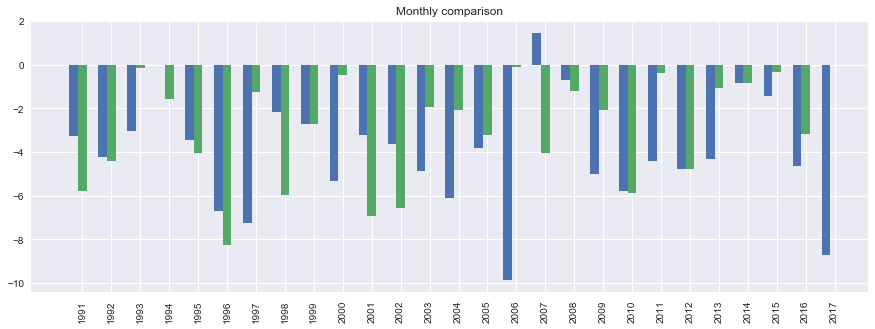

In [276]:
compare_months_bar(structured_result, (1, 12), 1991, max_year, default_width=0.3)

---

> **Question / Task:** Can you create a function which finds the warmest year and the coldest year for a station an plots the data into same graph?

---
> **CODE_NOTE** To be done later!